In [1]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
from tqdm import tqdm
import time
import os

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

In [2]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 224, 224)
    save_image(img, name)
    
# helper functions
image_dir = '../outputs/saved_images'
os.makedirs(image_dir, exist_ok=True)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

batch_size = 2
epochs = 40


cuda:0


In [3]:
dataset = getDataset()

In [4]:
from sklearn.model_selection import train_test_split
random_state=42

x_train = dataset[0][0]
y_train = dataset[0][1]

x_test = dataset[1][0]
y_test = dataset[1][1]

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=random_state)

print(f"Train data instances: {len(x_train)}")
print(f"Validation data instances: {len(x_val)}")
print(f"Test data instances: {len(x_test)}")

Train data instances: 40000
Validation data instances: 10000
Test data instances: 10000


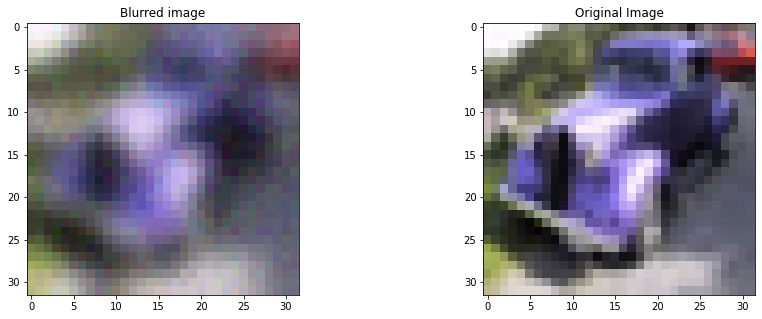

In [5]:
import matplotlib.pyplot as plt

# Choose an image from the test set
idx = np.random.randint(0, len(x_test))
x = x_test[idx]
y = y_test[idx]

# Plot the masked input and generated output
f, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(x)
ax[0].set_title('Blurred image')
ax[1].imshow(y)
ax[1].set_title('Original Image')
plt.show()

In [6]:
import tensorflow as tf
from tensorflow.keras import layers

def build_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    return model

model = build_model()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 128)      0

In [7]:
batch_size=256
epochs = 30

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val) )

Epoch 1/30
157/157 [==============================] - 16s 44ms/step - loss: 0.0172 - val_loss: 0.0082
Epoch 2/30
157/157 [==============================] - 6s 38ms/step - loss: 0.0075 - val_loss: 0.0095
Epoch 3/30
157/157 [==============================] - 6s 37ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 4/30
157/157 [==============================] - 6s 38ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 5/30
157/157 [==============================] - 6s 37ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 6/30
157/157 [==============================] - 6s 37ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 7/30
157/157 [==============================] - 6s 37ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 8/30
157/157 [==============================] - 6s 37ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 9/30
157/157 [==============================] - 6s 37ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 10/30
157/157 [==============================] - 6s 37ms/step - loss: 0.0047 - val_l

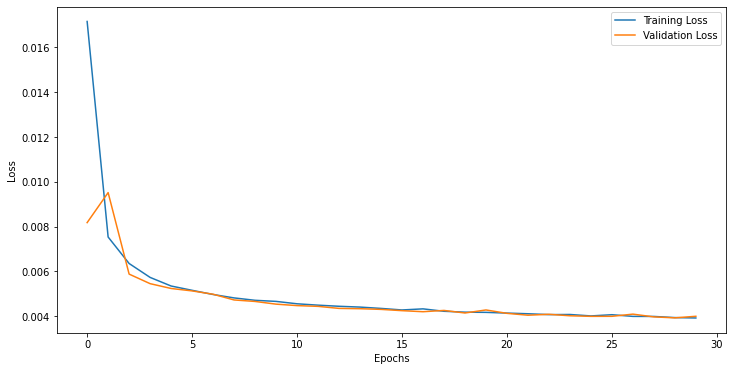

In [8]:
history = model.history

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.show()

In [9]:
# Evaluate the model on the test data
test_loss = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)

313/313 [==============================] - 1s 4ms/step - loss: 0.0040
Test loss: 0.003992822486907244


1/1 [==============================] - 0s 20ms/step


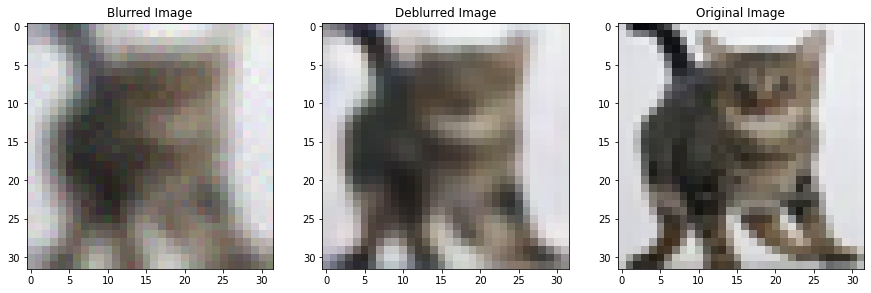

In [71]:
import matplotlib.pyplot as plt

# Choose a random image from the test set
idx = np.random.randint(0, len(x_test))
blur_img = x_test[idx]
orig_img = y_test[idx]

# Predict the deblurred image using the model
deblurred_img = model.predict(np.expand_dims(blur_img, axis=0))[0]

# Plot the blurred input, deblurred output, and original image
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(blur_img)
ax[0].set_title('Blurred Image')
ax[1].imshow(deblurred_img)
ax[1].set_title('Deblurred Image')
ax[2].imshow(orig_img)
ax[2].set_title('Original Image')
plt.show()
